In [10]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from zca import zca
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import OLSInfluence
import statsmodels.api as sm
import statsmodels.tools
from OLS_LR_DiagnosticPlots.ModelDiagnostics import Plot
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, RepeatedKFold, train_test_split

from mlxtend.feature_selection import SequentialFeatureSelector as sfbs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfbs
import matplotlib.pyplot as plt
from tqdm import tnrange, tqdm_notebook
import itertools
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import sys

from ipydatagrid import DataGrid

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [2]:
target = 'Price'
numCV = 10

car_data = pd.read_csv("C:\\Users\\User\\Documents\\business\\cars\\cars.csv")
car_data.index = car_data["Concat"]
car_data = car_data[set(car_data.columns).difference('Concat')].copy()
X = car_data[set(car_data.columns).difference([target,'Concat'])].copy()
y = pd.DataFrame(car_data[target])


In [3]:
yscaler = StandardScaler()
xscaler = StandardScaler()
zca = zca.ZCA()
kfold = KFold(n_splits=numCV, shuffle=True)

In [4]:
lr = LinearRegression()

#backwards step subset
sfbs1 = sfbs(lr, 
          k_features=len(X.columns), 
          #forward=True, 
          floating=True, 
          scoring='neg_mean_squared_error',
          #scoring='accuracy',
          n_jobs=-1,
          cv=numCV)
            
sfbs1 = sfbs1.fit(X, y)


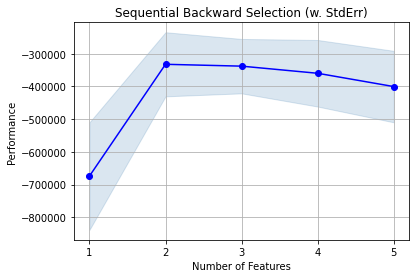

In [5]:
fig = plot_sfbs(sfbs1.get_metric_dict(), kind='std_err')

plt.title('Sequential Backward Selection (w. StdErr)')
plt.grid()
plt.show()

In [6]:
features = list(pd.DataFrame(sfbs1.subsets_).loc['feature_names'].values)
ss_position = np.array(pd.DataFrame(pd.DataFrame(sfbs1.subsets_)).loc['avg_score']).argmax()
pd.DataFrame(sfbs1.subsets_).T[['avg_score','feature_names']]

,avg_score,feature_names
1,-674008.016609,"(Year,)"
2,-332396.754971,"(Year, maintenance)"
3,-338041.11011,"(Year, maintenance, Miles)"
4,-359857.087655,"(Year, maintenance, Miles, estMPG)"
5,-400456.41928,"(Comfort, Year, maintenance, Miles, estMPG)"


In [7]:
def fit_linear_reg(X,Y,train_i,test_i):
    #Fit linear regression model and return RSS and R squared values
    model_k = linear_model.LinearRegression(fit_intercept = True)
    model_k.fit(X.iloc[train_i],Y.iloc[train_i])
    RSS = mean_squared_error(Y.iloc[test_i],model_k.predict(X.iloc[test_i])) * len(Y)
    R_squared = model_k.score(X.iloc[test_i],Y.iloc[test_i])
    return RSS, R_squared

# ransac regression on a dataset with outliers

# evaluate a model
def evaluate_model(X, y, model):
	# define model evaluation method
	cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
	# force scores to be positive
	return absolute(scores)

# plot the dataset and the model's line of best fit
def plot_best_fit(X, y, model):
	# fut the model on all data
	model.fit(X, y)
	# plot the dataset
	pyplot.scatter(X, y)
	# plot the line of best fit
	xaxis = arange(X.min(), X.max(), 0.01)
	yaxis = model.predict(xaxis.reshape((len(xaxis), 1)))
	pyplot.plot(xaxis, yaxis, color='r')
	# show the plot
	pyplot.title(type(model).__name__)
	pyplot.show()

In [8]:
#used for pcorr kfolds as well as best subsets
kfold.get_n_splits(car_data.index)

train_ = []
test_ = []

for train_indices, test_indices in kfold.split(car_data.index):
    train_.append(train_indices)
    test_.append(test_indices)

In [9]:
scaler.fit_transform(X)

NameError: name 'scaler' is not defined

In [ ]:

#import random

#best subsets using pcorr chosen

#Importing tqdm for the progress bar

#Initialization variables
yscaler.fit(y)
Y = pd.DataFrame(yscaler.transform(y))
Y.index = y.index
Y.columns = y.columns
#X = all_data.iloc[:,2:]
#Xcolumns = X_train[chosen]
xscaler.fit(X)
x_scaled = pd.DataFrame(xscaler.transform(X))
x_scaled.index = X.index
x_scaled.columns = X.columns
k = numCV
RSS_list, R_squared_list, feature_list = [],[], []
numb_features = []

#Looping over k = 1 to k = 11 features in X
for k in tnrange(1,len(Xcolumns) + 1, desc = 'Loop...'):

    #Looping over all possible combinations: from 11 choose k
    for combo in itertools.combinations(x_scaled.columns,k):
        #display(all_data.iloc[test_index].describe())
        tmp_result = []
        for it in range(0,len(train_)):
            tmp_result.append(fit_linear_reg(Xcolumns[list(combo)],Y,train_[it],test_[it]))   #Store temp result )
        
        RSS_list.append(np.average(tmp_result,axis=0)[0])                  #Append lists
        R_squared_list.append(np.average(tmp_result,axis=0)[1])
        feature_list.append(combo)
        numb_features.append(len(combo))   

#Store in DataFrame
df = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 'R_squared':R_squared_list,'features':feature_list})

df['min_RSS'] = df.groupby('numb_features')['RSS'].transform(min)
df['max_R_squared'] = df.groupby('numb_features')['R_squared'].transform(max)

df_min = df[df.groupby('numb_features')['RSS'].transform(min) == df['RSS']]
df_max = df[df.groupby('numb_features')['R_squared'].transform(max) == df['R_squared']]

df_min


CV_parse = list(df_min[(df_min['RSS']<=(np.min(df_min['RSS'])+np.std(df_min['RSS'])))].sort_values(kind="quicksort", ascending=True, by='RSS',key=abs).iloc[0]['features'])

In [ ]:
CV_best = list(df_min['RSS']==(np.min(df_min['RSS'])+np.std(df_min['RSS'])))

In [ ]:
df_min.loc[df_min['RSS'].idxmin()]

In [ ]:
CV_parse

In [ ]:
#zca.fit(X)
#yscaler.fit(y)
#xscaler.fit(X)
zca_X = pd.DataFrame(zca.fit_transform(x_scaled[CV_parse]),columns=x_scaled[CV_parse].columns)
y_scaled = Y
#y_scaled = pd.DataFrame(yscaler.transform(np.array(y).reshape(-1, 1)))
#y_scaled.index = y.index
#x_scaled = pd.DataFrame(xscaler.transform(X))
#x_scaled.index = X.index
#x_scaled.columns = X.columns

In [ ]:
#model = LinearRegression()
#model.fit(zca_X, y_scaled)

X_trainwConstant = statsmodels.tools.tools.add_constant(x_scaled[CV_parse])
#y_ = data_set_wConstant[target]
#results = model.fit(X, y)
model = sm.OLS(y_scaled,X_trainwConstant)
results = model.fit()
fitted = results.predict(X_trainwConstant)
results.summary()

In [ ]:
linear_plot = Plot.LinearRegressionResidualPlot(X_trainwConstant.values, y_scaled.values)
lm = linear_plot.fit()
summary, diag_res = linear_plot.diagnostic_plots(lm)
print("Summary of Regression\n:{}".format(summary))
print("Diagnostic Tests of Regression\n:{}".format(diag_res))
car_data